In [1]:
import numpy as np
import pandas as pd
import os
from pandas import *
from scipy.linalg import solve, eig
import matplotlib.pyplot as plt
from scipy.stats import t, norm, shapiro, chi2, jarque_bera, kstest, anderson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from pyproj import Transformer

In [2]:
# Data Import
data = pd.read_excel(r"C:\Users\zrclm\Documents\Ezra\Kuliah\Tugas Akhir\Data\GWL Riau Dummy.xlsx", sheet_name='Interpolated')
loc = data.iloc[:, 0].tolist()

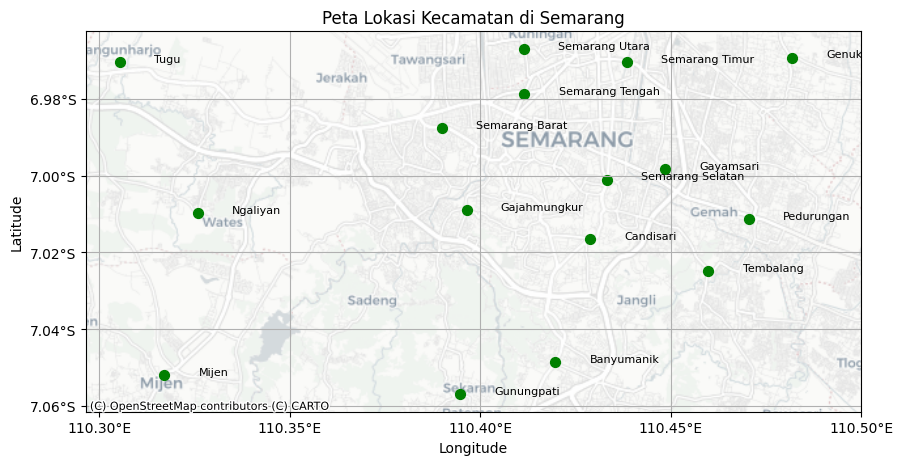

In [14]:
# Define the data
lokasi = {
    'Kecamatan': [
        'Banyumanik', 'Candisari', 'Gajahmungkur', 'Gayamsari', 'Genuk', 'Gunungpati',
        'Mijen', 'Ngaliyan', 'Pedurungan', 'Semarang Barat', 'Semarang Selatan',
        'Semarang Tengah', 'Semarang Timur', 'Semarang Utara', 'Tembalang', 'Tugu'
    ],
    'Bujur': [
        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,
        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,
        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704
    ],
    'Lintang': [
        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,
        110.317, 110.3259, 110.4705, 110.3899, 110.4333,
        110.4116, 110.4386, 110.4114, 110.4599, 110.3053
    ]
}

# Create GeoDataFrame in EPSG:4326
df = pd.DataFrame(lokasi)
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df['Lintang'], df['Bujur'])],
    crs="EPSG:4326"
)

# Project to EPSG:3857 for contextily basemap
gdf_web = gdf.to_crs(epsg=3857)

# Plot setup
fig, ax = plt.subplots(figsize=(10, 8))
gdf_web.plot(ax=ax, color='green', markersize=50)

# Add kecamatan labels
for x, y, label in zip(gdf_web.geometry.x, gdf_web.geometry.y, gdf_web['Kecamatan']):
    ax.text(x + 1000, y, label, fontsize=8)

# Add basemap (Stamen Terrain Background)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)


# Set limits from data
# Get bounds
xmin, ymin, xmax, ymax = gdf_web.total_bounds

# Add some padding (in meters)
x_pad = (xmax - xmin) * 0.05  # 5% padding
y_pad = (ymax - ymin) * 0.05

# Set new limits with padding
ax.set_xlim(xmin - x_pad, xmax + x_pad)
ax.set_ylim(ymin - y_pad, ymax + y_pad)

# Convert desired degree ticks into projected (meter) ticks
transformer = Transformer.from_crs(4326, 3857)

# Longitude (Lintang) ticks for x-axis
x_deg = [110.30, 110.35, 110.40, 110.45, 110.50]
x_ticks = [transformer.transform(-7.0, x)[0] for x in x_deg]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:.2f}°E" for x in x_deg])

# Latitude (Bujur) ticks for y-axis
y_deg = [-7.06, -7.04, -7.02, -7.00, -6.98]
y_ticks = [transformer.transform(y, 110.4)[1] for y in y_deg]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{abs(y):.2f}°S" for y in y_deg])  # abs for positive label

# Add labels and grid
ax.set_title("Peta Lokasi Kecamatan di Semarang")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.show()

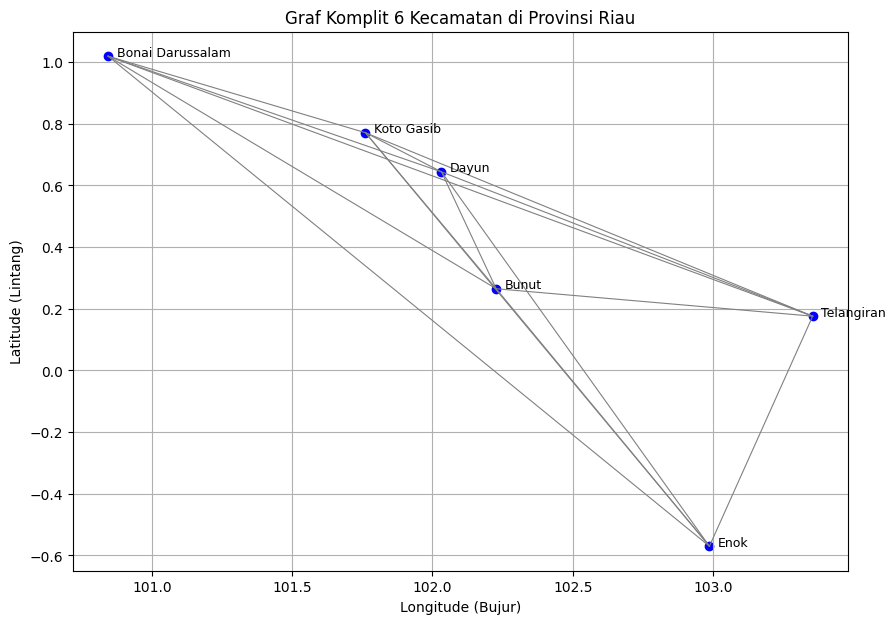

In [ ]:
'''
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations

# Define the coordinates
data = {
    'Lokasi': ['Enok', 'Koto Gasib', 'Telangiran', 'Bonai Darussalam', 'Bunut', 'Dayun'],
    'Bujur': [102.987, 101.761, 103.355, 100.844, 102.227, 102.032],
    'Lintang': [-0.570, 0.771, 0.176, 1.019, 0.265, 0.644]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot setup
plt.figure(figsize=(10, 7))

# Plot the points
plt.scatter(df['Bujur'], df['Lintang'], color='blue')

# Add labels
for i in range(len(df)):
    plt.text(df['Bujur'][i] + 0.03, df['Lintang'][i], df['Lokasi'][i], fontsize=9)

# Draw lines between every pair of points (complete graph)
for i, j in combinations(range(len(df)), 2):
    x_coords = [df['Bujur'][i], df['Bujur'][j]]
    y_coords = [df['Lintang'][i], df['Lintang'][j]]
    plt.plot(x_coords, y_coords, color='gray', linewidth=0.8)

# Axis and title
plt.xlabel('Longitude (Bujur)')
plt.ylabel('Latitude (Lintang)')
plt.title('Graf Komplit 6 Kecamatan di Provinsi Riau')
plt.grid(True)
plt.show()
'''

In [4]:
"""MINIMUM SPANNING TREE Berdasarkan Jarak"""
# Adjacency Matrix (Euclidean Approach)
G = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if i == j:
            G[i][j] = 0
        else:
            G[i][j] = ((data['Longitude'][i]-data['Longitude'][j])**2 + 
                       (data['Latitude'][i]-data['Latitude'][j])**2)**(0.5)

# MST Computation (Kruskal Algorithm)
INF = 9999999
N = len(data)
selected_node = [0 for i in range(N)]
no_edge = 0
x_mst = []
y_mst = []
w_mst = []
selected_node[0] = True

while (no_edge < N- 1):
    minimum = INF
    a = 0
    b = 0
    for m in range(N):
        if selected_node[m]:
            for n in range(N):
                if ((not selected_node[n]) and G[m][n]):
                    if minimum > G[m][n]:
                        minimum = G[m][n]
                        a = m
                        b = n

    x_mst.append(a)
    y_mst.append(b)
    w_mst.append(G[a][b])
    selected_node[b] = True
    no_edge += 1

# Adjacency Matrix for MST
G_mst = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(x_mst)):
    for j in range(len(x_mst)):
        G_mst[x_mst[i]][y_mst[i]] = w_mst[i]
        G_mst[y_mst[i]][x_mst[i]] = w_mst[i]

#W0
W0 = np.eye(6)

# W1
W = [[0 for j in range(len(data))] for i in range(len(data))]
W1 = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if G_mst[i][j]:
            W[i][j] = ((data['Longitude'][i]-data['Longitude'][j])**2 + 
                       (data['Latitude'][i]-data['Latitude'][j])**2)**(-0.5)
for i in range(len(data)):
    for j in range(len(data)):
        W1[i][j] = W[i][j]/sum(W[i])

# W2
W = [[0 for j in range(len(data))] for i in range(len(data))]
W2 = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if G_mst[i][j]:
            for k in range(len(data)):
                if W1[j][k] and i!=k:
                    W[i][k] = ((data['Longitude'][i]-data['Longitude'][k])**2 + 
                               (data['Latitude'][i]-data['Latitude'][k])**2)**(-0.5)
for i in range(len(data)):
    for j in range(len(data)):
        W2[i][j] = W[i][j]/sum(W[i])

# W3
W = [[0 for j in range(len(data))] for i in range(len(data))]
W3 = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if G_mst[i][j]:
            for k in range(len(data)):
                if G_mst[j][k] and i!=k:
                    for l in range(len(data)):
                        if G_mst[k][l] and j!=l:
                            W[i][l] = ((data['Longitude'][i]-data['Longitude'][l])**2 + 
                                       (data['Latitude'][i]-data['Latitude'][l])**2)**(-0.5)
                            
for i in range(len(data)):
    for j in range(len(data)):
        W3[i][j] = W[i][j]/sum(W[i])

print(G)

[[0, np.float64(1.816963676026573), np.float64(0.8318293094139005), np.float64(2.6678399502219023), np.float64(1.1290814851019328), np.float64(1.5446103068411774)], [np.float64(1.816963676026573), 0, np.float64(1.7014291051936388), np.float64(0.9499436825412351), np.float64(0.687889526014176), np.float64(0.2992824752637555)], [np.float64(0.8318293094139005), np.float64(1.7014291051936388), 0, np.float64(2.6487298843030502), np.float64(1.1315056340999812), np.float64(1.4033363816277336)], [np.float64(2.6678399502219023), np.float64(0.9499436825412351), np.float64(2.6487298843030502), 0, np.float64(1.575184116222617), np.float64(1.245780478254498)], [np.float64(1.1290814851019328), np.float64(0.687889526014176), np.float64(1.1315056340999812), np.float64(1.575184116222617), 0, np.float64(0.4262229463555463)], [np.float64(1.5446103068411774), np.float64(0.2992824752637555), np.float64(1.4033363816277336), np.float64(1.245780478254498), np.float64(0.4262229463555463), 0]]


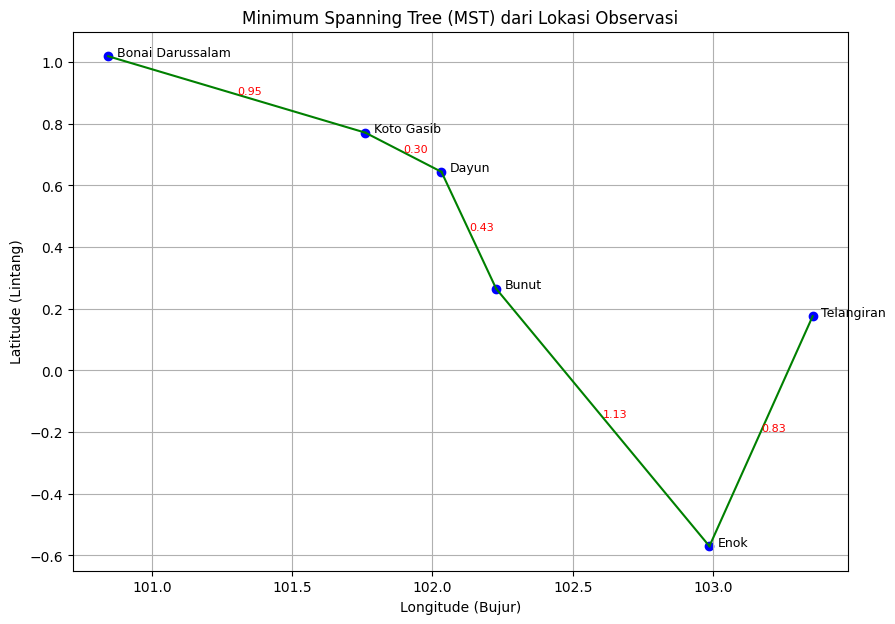

In [ ]:
'''
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the coordinates
data = {
    'Lokasi': ['Enok', 'Koto Gasib', 'Telangiran', 'Bonai Darussalam', 'Bunut', 'Dayun'],
    'Bujur': [102.987, 101.761, 103.355, 100.844, 102.227, 102.032],
    'Lintang': [-0.570, 0.771, 0.176, 1.019, 0.265, 0.644]
}

# MST adjacency matrix
mst_matrix = [
    [0, 0, 0.8318293094139005, 0, 1.1290814851019328, 0],
    [0, 0, 0, 0.9499436825412351, 0, 0.2992824752637555],
    [0.8318293094139005, 0, 0, 0, 0, 0],
    [0, 0.9499436825412351, 0, 0, 0, 0],
    [1.1290814851019328, 0, 0, 0, 0, 0.4262229463555463],
    [0, 0.2992824752637555, 0, 0, 0.4262229463555463, 0]
]
mst_matrix = np.array(mst_matrix)

# Create DataFrame
df = pd.DataFrame(data)

# Start plot
plt.figure(figsize=(10, 7))
plt.scatter(df['Bujur'], df['Lintang'], color='blue')

# Add location labels
for i in range(len(df)):
    plt.text(df['Bujur'][i] + 0.03, df['Lintang'][i], df['Lokasi'][i], fontsize=9)

# Plot MST edges
n = len(df)
for i in range(n):
    for j in range(i + 1, n):  # Avoid duplicate lines
        weight = mst_matrix[i][j]
        if weight > 0:
            # Draw the line
            x_coords = [df['Bujur'][i], df['Bujur'][j]]
            y_coords = [df['Lintang'][i], df['Lintang'][j]]
            plt.plot(x_coords, y_coords, color='green', linewidth=1.5)

            # Label with weight at midpoint
            mid_x = (x_coords[0] + x_coords[1]) / 2
            mid_y = (y_coords[0] + y_coords[1]) / 2
            plt.text(mid_x, mid_y, f"{weight:.2f}", color='red', fontsize=8)

# Final touches
plt.xlabel('Longitude (Bujur)')
plt.ylabel('Latitude (Lintang)')
plt.title('Minimum Spanning Tree (MST) dari Lokasi Observasi')
plt.grid(True)
plt.show()
'''

In [91]:
W_MST = [W0, W1, W2, W3]
print(W1)
# Parameters
phi_10 = np.diag([0.02, 0.5, 0.0956, 0.137, 0.0523, 0.012])
phi_20 = np.diag([0.123, 0.013, 0.342, 0.0451, 0.5, 0.06])
phi_21 = np.diag([0.232, 0.093, 0.01442, 0.023, 0.0429, 0.203])

B1 = phi_10
B2 = phi_20 + phi_21 @ W1

I = np.eye(6)
O = np.zeros((6, 6))
B = np.block([[B1, B2], [I, O]])

M_2 = np.block([[I, -(B1.T)], [-B1, I]]) - np.block([[(B2.T)@B2, (B1.T@B2).T], [B1.T@B2, B2.T@B2]])

# Helper Functions
def get_submatrices(A):
    """Get all leading principal submatrices of matrix A."""
    n = A.shape[0]
    submatrices = [A[:i+1, :i+1] for i in range(n)]
    return submatrices

def get_determinants(submatrices):
    """Calculate determinants of submatrices."""
    return [np.linalg.det(sub) for sub in submatrices]


# Get Submatrices and Determinants
submatrices = get_submatrices(M_2)
determinants = get_determinants(submatrices)
print("Determinants of submatrices:", determinants)
if all(i > 0 for i in determinants) :
    print('Stationary in terms of IAcM')
else:
    print('Non-stationary in terms of IAcM')
# Eigenvalues and Stationarity Check
eigenvalues = np.abs(np.linalg.eigvals(B))
print(eigenvalues)

if np.max(eigenvalues) < 1:
    print("Stationary because the eigenvalues of the Autocovariance Matrix are less than 1.")
else :
    print('Non Stationary because the eigenvalues of the Autocovariance Matrix are greater than 1.')

[[np.float64(0.0), np.float64(0.0), np.float64(0.5757944156662737), np.float64(0.0), np.float64(0.42420558433372624), np.float64(0.0)], [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.23957429436926247), np.float64(0.0), np.float64(0.7604257056307375)], [np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], [np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], [np.float64(0.2740447064476836), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.7259552935523164)], [np.float64(0.0), np.float64(0.5874841643557013), np.float64(0.0), np.float64(0.0), np.float64(0.41251583564429867), np.float64(0.0)]]
Determinants of submatrices: [np.float64(0.9845248478867117), np.float64(0.9698349720371066), np.float64(0.8386431682421239), np.float64(0.8365195441899295), np.float64(0.6128845705468052), np.float64(0.6066184289053957), np.float64(0.596908211352386),

In [92]:
data = data.iloc[:, 3:]
cov_mat = np.cov(data)

var_e = np.diag(cov_mat) * (1 - np.diag(phi_10)**2 - (np.diag(phi_20) + np.dot(phi_21, W1))**2)
stdev = np.sqrt(np.diag(var_e))
print(np.diag(var_e))

[0.00732024 0.00841103 0.01168144 0.06425641 0.14431473 0.01372152]


In [93]:
T = 100
#Generate Data
def Yt(phi_10, phi_20, phi_21, W, T, N):

    Y = np.zeros((N, T))
    
    Y[:, 0] = np.zeros(N)
    Y[:, 1] = np.zeros(N)
    

    for t in range(2, T):
        Y[:, t] = np.dot(phi_10, Y[:, t-1]) + np.dot((phi_20 + np.dot(phi_21, W)), Y[:, t-2]) + np.random.normal(loc=0, scale=stdev, size=N)
    
    return Y

def export_data_sim_with_increment(data_sim, T, folder='.', extension='.xlsx'):
    """
    Exports `data_sim` DataFrame to Excel with an auto-incremented filename 
    based on T value, avoiding overwriting existing files.

    Parameters:
        data_sim (pd.DataFrame): DataFrame to export
        T (int or str): Time value to include in the filename
        folder (str): Folder to save file into
        extension (str): File extension (default .xlsx)
    """
    base_filename = f"Data Generate, Phi_1 t={T}"
    i = 0
    while True:
        if i == 0:
            filename = f"{base_filename}{extension}"
        else:
            filename = f"{base_filename}_{i}{extension}"
        filepath = os.path.join(folder, filename)
        if not os.path.exists(filepath):
            break
        i += 1

    data_sim.to_excel(filepath, index=False)
    print(f"File saved as: {filepath}")

coords = pd.DataFrame({
    'Longitude': [102.987, 101.761, 103.355, 100.844, 102.227, 102.032],
    'Latitude': [-0.570, 0.771, 0.176, 1.019, 0.265, 0.644]
})
num_sim = 1000
num_files = 250

for file_num in range(num_files):
    all_Y = np.zeros((N, T, num_sim))
    
    for i in range(num_sim):
        all_Y[:, :, i] = Yt(phi_10, phi_20, phi_21, W1, T, N)

    Y_sim = np.mean(all_Y, axis=2)

    data_sim = pd.DataFrame(Y_sim)
    data_sim.insert(0, 'Location', loc)
    weeks = [f"Week {i+1}" for i in range(Y_sim.shape[1])]  # Create week labels from 'Week 1' to 'Week 100'
    new_columns = ['Location'] + weeks  # Add 'Location' to the beginning of the list
    data_sim.columns = new_columns
    df_left = data_sim.iloc[:, :1]   # col 1
    df_right = data_sim.iloc[:, 1:]  
    data_sim = pd.concat([df_left, coords, df_right], axis=1)
    export_data_sim_with_increment(data_sim, T)

File saved as: .\Data Generate, Phi_1 t=100.xlsx
File saved as: .\Data Generate, Phi_1 t=100_1.xlsx
File saved as: .\Data Generate, Phi_1 t=100_2.xlsx
File saved as: .\Data Generate, Phi_1 t=100_3.xlsx
File saved as: .\Data Generate, Phi_1 t=100_4.xlsx
File saved as: .\Data Generate, Phi_1 t=100_5.xlsx
File saved as: .\Data Generate, Phi_1 t=100_6.xlsx
File saved as: .\Data Generate, Phi_1 t=100_7.xlsx
File saved as: .\Data Generate, Phi_1 t=100_8.xlsx
File saved as: .\Data Generate, Phi_1 t=100_9.xlsx
File saved as: .\Data Generate, Phi_1 t=100_10.xlsx
File saved as: .\Data Generate, Phi_1 t=100_11.xlsx
File saved as: .\Data Generate, Phi_1 t=100_12.xlsx
File saved as: .\Data Generate, Phi_1 t=100_13.xlsx
File saved as: .\Data Generate, Phi_1 t=100_14.xlsx
File saved as: .\Data Generate, Phi_1 t=100_15.xlsx
File saved as: .\Data Generate, Phi_1 t=100_16.xlsx
File saved as: .\Data Generate, Phi_1 t=100_17.xlsx
File saved as: .\Data Generate, Phi_1 t=100_18.xlsx
File saved as: .\Data Ge

In [94]:
'''
#Uji Kestasioneran Data Hasil Simulasi
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return p-value from the ADF test

# Iterate through each row and perform the ADF test for each location
p_values = {}

for index, row in data_sim.iterrows():
    location = row['Location']
    location_data = row[1:]  # All columns except the first one (Location)
    p_value = adf_test(location_data)
    p_values[location] = p_value

# Display the results
for location, p_value in p_values.items():
    print(f"Location: {location} - p-value: {p_value}")
    if p_value < 0.05:
        print(f"{location} is stationary.")
    else:
        print(f"{location} is not stationary.")
'''

'\n#Uji Kestasioneran Data Hasil Simulasi\ndef adf_test(series):\n    result = adfuller(series)\n    return result[1]  # Return p-value from the ADF test\n\n# Iterate through each row and perform the ADF test for each location\np_values = {}\n\nfor index, row in data_sim.iterrows():\n    location = row[\'Location\']\n    location_data = row[1:]  # All columns except the first one (Location)\n    p_value = adf_test(location_data)\n    p_values[location] = p_value\n\n# Display the results\nfor location, p_value in p_values.items():\n    print(f"Location: {location} - p-value: {p_value}")\n    if p_value < 0.05:\n        print(f"{location} is stationary.")\n    else:\n        print(f"{location} is not stationary.")\n'